In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
#plt.rc('text', usetex=True)

from mpl_toolkits import mplot3d

# 1)

In [2]:
data = np.transpose(np.loadtxt('dish_zenith.txt'))
plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(data[0], data[1], data[2], color='black')

<IPython.core.display.Javascript object>

## a,b) LLS fitting

The equation for a rotationally symmetric paraboloid can be re-written from
$$ z-z_0 = a((x-x_0)^2 + (y-y_0)^2) $$
to
$$ z = c_1x^2 + c_2x + c_1y^2 + c_3y + c_4 $$
where
$$ c_1 = a      \\
   c_2 = -2ax_0 \\
   c_3 = -2ay_0 \\
   c_4 = a{x_0}^2 + a{y_0}^2 + z_0 \text{ .} \\
$$
Once the $c_i$ are found, the parameters $a$, $x_0$, $y_0$ and $z_0$ are defined as
$$ a = c_1 \\
\\ x_0 = \frac{-c_2}{2c_1} \\
\\ y_0 = \frac{-c_3}{2c_1} \\
\\ z_0 = c_4 - c_1({x_0}^2 + {y_0}^2) \\
$$

In [3]:
def recoverParams(pars):
    c1,c2,c3,c4 = pars
    x0 = -c2/(2*c1);   y0 = -c3/(2*c1)
    return c1 , x0 , y0 , c4 - c1*(x0**2 + y0**2)

def paraboi(x,y,pars):
    a,x0,y0,z0 = pars
    return a*((x-x0)**2 + (y-y0)**2) + z0

def get_A_life(x,y):
    
    if len(x) != len(y):
        raise Error('X and Y dont have the same length')
        
    A = np.zeros([len(x),4])
    A[:,0] = x**2 + y**2
    A[:,1] = x
    A[:,2] = y
    A[:,3] = 1
    
    return A

In [4]:
    # getting the A-matrix
A = get_A_life(data[0],data[1])
    # getting fit pars
ls_pars = np.linalg.inv(A.T@A)@(A.T@data[2])
pred_paraboi = A@ls_pars
recov_pars = recoverParams(ls_pars)
    # Printing the acquired parameters
print('Least Square (Transformed) Parameters:')
print('c1 =',ls_pars[0],'/ c2 =',ls_pars[1],'/ c3 =',ls_pars[2],'/ c4 =',ls_pars[3],'\n')
print('Recovered parameters:')
print('a =',recov_pars[0],'/ x0 =',recov_pars[1],'/ y0 =',recov_pars[2],'/ z0 =',recov_pars[3],'\n')

Least Square (Transformed) Parameters:
c1 = 0.00016670445477401342 / c2 = 0.0004535990279793565 / c3 = -0.019411558852636 / c4 = -1512.3118166739073 

Recovered parameters:
a = 0.00016670445477401342 / x0 = -1.3604886221974717 / y0 = 58.22147608157965 / z0 = -1512.877210036788 



In [5]:
    # Sanity check to make sure parameter transforms were good
plt.figure(); plt.title('Residuals between predicted fits using different parametrizations' , y=1.05)
plt.xlabel('Data-point number');  plt.ylabel('Residuals (mm)')
plt.plot( pred_paraboi - paraboi(data[0],data[1],recov_pars) )

<IPython.core.display.Javascript object>

## c) Estimating noise and error in parameters

In [6]:
    # Noise estimate
noise_estim = np.std(pred_paraboi-data[2])
print('Estimated noise/STD is',noise_estim)

plt.figure(); plt.title('Residuals between LS fit and data')
plt.xlabel('Data-point number');  plt.ylabel('Residuals (mm)')
plt.plot( pred_paraboi - data[2] )

    # Parameter error estimate
Ninv = np.linalg.inv( np.eye(len(data[0]))/noise_estim**2 )
errs_pars = np.sqrt(np.diag(np.linalg.inv( A.T@Ninv@A )))
print('Parameter a =',recov_pars[0],'+/-',errs_pars[0])

Estimated noise/STD is 3.7683386487847317


<IPython.core.display.Javascript object>

Parameter a = 0.00016670445477401342 +/- 4.5434710173518985e-09


In [7]:
# Assuming that the deepest data point is centered at (x,y) = (0,0)
# Use all of our data points in dish_zenith.txt to calculate a mean and error for the focal length
deepest = np.argmin(data[2])
Fs = np.empty(len(data[0])-1)
for i in range(len(Fs)):
    if i != deepest:
        Fs[i] = (data[0][i]**2+data[1][i]**2)/(4*(data[2][i]-data[2][deepest]))
        
#Fs = (data[0]**2+data[1]**2)/(4*(paraboi(data[0],data[1],recov_pars)-recov_pars[3]))

f_mean = np.mean( Fs )
f_std = np.std(Fs,ddof=1)
print('Dish has focal length of ('+str(f_mean/1000)+' +/- '+str(f_std/np.sqrt(len(data[0]))/1000)+') meters')

plt.figure(); plt.title('Values of focal length using all data ')
plt.xlabel('Data-point number');  plt.ylabel('Focal Length (mm)')
plt.plot(Fs)

Dish has focal length of (1.4983021233867229 +/- 0.014563236642557114) meters


<IPython.core.display.Javascript object>

# 2)

In [8]:
import camb

In [9]:
def chisq(data , model , sigma):
    return np.sum(((data-model)/sigma)**2)

# From 'wmap_camb_example.py' with some tweaks
def get_spectrum(pars,l_range=[0,2000],doPrint=False):
    if doPrint: print('pars are ',pars)
    l_range = np.array(l_range,dtype=np.int)
    H0 , ombh2 , omch2 , tau , As , ns = pars
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(l_range[1],lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[l_range[0]:l_range[1]+1,0]
    return tt

In [10]:
pars=np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
wmap=np.loadtxt('wmap_tt_spectrum_9yr_v5.txt')

plt.figure()
plt.plot(wmap[:,0],wmap[:,1],'.')
cmb=get_spectrum( pars , l_range=[np.min(wmap[:,0]),np.max(wmap[:,0])] )
plt.plot(cmb)

chi = chisq(wmap[:,1] , cmb , wmap[:,2])
print('Chi^2 =',chi)

<IPython.core.display.Javascript object>

Chi^2 = 1588.4257943681487


# 3)

In [20]:
def get_camb_derivs(pars,par_names , l_range , is_free_param , param_steps , doPlot=False , doPrint=False):
    
    l_range = np.array(l_range,dtype=np.int)
    derivs = np.zeros( (l_range[1]-l_range[0]+1 , len(pars)) )
        # where we keep parameters constant, we desire their dx to be zero when we print it to screen
    param_steps = np.where( is_free_param , param_steps , 0.0 )
    #if doPrint: print('Param dx sizes are',param_steps)
    if doPlot: plt.figure()
    
    for i in range(len(pars)):
        if is_free_param[i]:
            # Here the derivative technique used approxiamtes f'(x) to be ( f(x-dx) + f(x+dx) ) / 2dx
            if doPrint: print('Now deriving for param',par_names[i])
            pars_left, pars_right = pars.copy(), pars.copy()
            pars_left[i] = pars_left[i] - param_steps[i]
            pars_right[i] = pars_right[i] + param_steps[i]
            f_left = get_spectrum( pars_left , l_range )
            f_right = get_spectrum( pars_right , l_range )
            derivs[:,i] = (f_right-f_left) / (2*param_steps[i])
            if doPlot:
                plt.plot(np.arange(l_range[0],l_range[1]+1) , abs(derivs[:,i]) , label=par_names[i])
        
    if doPlot:
        plt.yscale('log'); plt.ylabel('Derivative of Power Spectrum');  plt.xlabel('l')
        plt.legend()
    return derivs

def runNewt_forCAMB( data , pars,par_names , l_range , is_free_param , param_steps , N , doPlot=False , doPrint=False):
    
    Ninv = np.linalg.inv(N)
    rezid = data - get_spectrum(pars , l_range)
    derivs = get_camb_derivs( pars,par_names , l_range , is_free_param , param_steps , doPlot=doPlot , doPrint=doPrint)
    derivs = np.transpose( np.transpose(derivs)[is_free_param] )
    lhs = derivs.T@(Ninv@derivs)
    rhs = derivs.T@(Ninv@rezid)
    change_in_pars = np.linalg.inv(lhs)@(rhs)
    for i in range(len(pars)):
        if not is_free_param[i]: change_in_pars = np.insert(change_in_pars , i , 0 ,axis=0)
    new_pars = pars + change_in_pars
    cov = np.linalg.inv(lhs)
    new_pars_errs = np.sqrt( np.diagonal( np.linalg.inv(lhs) ) )

    return new_pars , new_pars_errs , cov

## Setting tau as a constant

Pars are initially :  [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
ChiSq is initially :  62232.857518704375


<IPython.core.display.Javascript object>


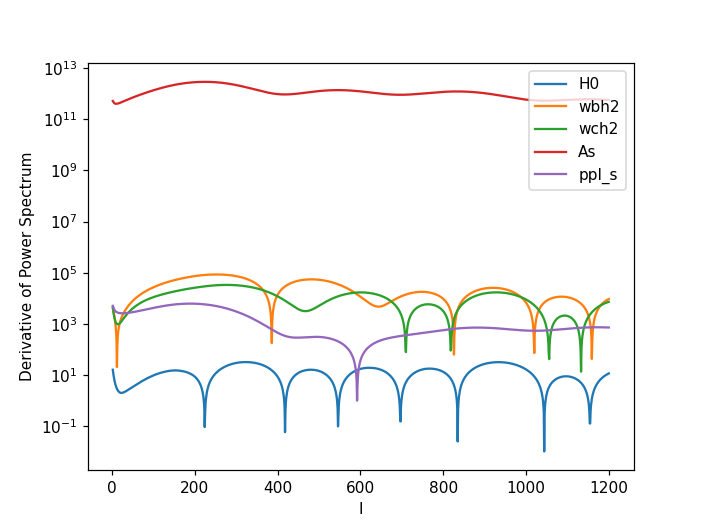

Now deriving for param H0
Now deriving for param wbh2
Now deriving for param wch2
Now deriving for param As
Now deriving for param ppl_s
@ Run#1, pars are now :  [6.73124746e+01 2.24535651e-02 1.16223431e-01 5.00000000e-02
 2.06933994e-09 9.66339416e-01]
ChiSq is 1235.030662197864 and changed by -60997.82685650651

@ Run#2, pars are now :  [6.92841137e+01 2.24918167e-02 1.13991614e-01 5.00000000e-02
 2.04299606e-09 9.69666917e-01]
ChiSq is 1227.9218068143912 and changed by -7.108855383472928

@ Run#3, pars are now :  [6.93253396e+01 2.24903636e-02 1.13913435e-01 5.00000000e-02
 2.04238002e-09 9.69705439e-01]
ChiSq is 1227.9208259936213 and changed by -0.0009808207698824845

@ Run#4, pars are now :  [6.93252846e+01 2.24903362e-02 1.13913235e-01 5.00000000e-02
 2.04237806e-09 9.69705081e-01]
ChiSq is 1227.92082496996 and changed by -1.0236612979497295e-06

Final Parameters are [6.93252846e+01 2.24903362e-02 1.13913235e-01 5.00000000e-02
 2.04237806e-09 9.69705081e-01]
Assuming no correla

In [21]:
# Initial parameter guesses
pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pnames = ['H0' , 'wbh2' , 'wch2' , 'tau' , 'As' , 'ppl_s']
l_range = [ np.min(wmap[:,0]) , np.max(wmap[:,0]) ]
# The boolean array that'll keep track of which parameters are floated
is_free_param = [True,True,True,False,True,True]
# Initializing the parameter step sizes as a fraction of their parameter values
param_steps = pars * 0.05
# The estimated noise matrix based on an assumption of uncorrelated errors
N = np.diag(wmap[:,2]**2)

new_pars = pars.copy()
kaisq = chisq(wmap[:,0],get_spectrum(new_pars,l_range),wmap[:,2])
print('Pars are initially : ',new_pars)
print('ChiSq is initially : ',kaisq)
delta_kai = -9000;  count = 0

# While we are strictly decreasing chi-squared, and the decrease value is not too small, continually loop Newton's method
while delta_kai < 0 and np.abs(delta_kai) >= 1e-4 and count < 10: 
    if count==0:
        doPlot=True; doPrint=True
    else:
        doPlot=False; doPrint=False
    new_pars , new_pars_errs , cov_matrix = runNewt_forCAMB( wmap[:,1] , new_pars,pnames , l_range , is_free_param , param_steps , N , doPlot=doPlot , doPrint=doPrint)
    updated_model = get_spectrum(new_pars,l_range)
    updated_kaisq = chisq(wmap[:,1], updated_model , wmap[:,2])
    delta_kai = updated_kaisq - kaisq
    count+=1
    print('@ Run#'+str(count)+', pars are now : ',new_pars)
    print('ChiSq is',updated_kaisq,'and changed by',delta_kai)
    kaisq = updated_kaisq
    print('')

print('Final Parameters are',new_pars)
print('Assuming no correlation, errors in params are',new_pars_errs)

### We observe that the derivatives do not change drastically over the interval. They also do not blow up towards either extremes of the allowed floating point values. We can therefore be confident that those derivatives are not being limited by round-off errors.

## Setting tau as float
### By letting tau go free,  the errors in the parameters might change due the the covariance matrix being further modified. In general, as more parameters are set free, the likelyhood of them being correlated increases

In [22]:
# Initial parameter guesses
pars = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pnames = ['H0' , 'wbh2' , 'wch2' , 'tau' , 'As' , 'ppl_s']
l_range = [ np.min(wmap[:,0]) , np.max(wmap[:,0]) ]
# The boolean array that'll keep track of which parameters are floated
is_free_param = [True,True,True,True,True,True]
# Initializing the parameter step sizes as a fraction of their parameter values
param_steps = pars * 0.05
# The estimated noise matrix based on an assumption of uncorrelated errors
N = np.diag(wmap[:,2]**2)

new_pars2 = pars.copy()
kaisq = chisq(wmap[:,0],get_spectrum(new_pars,l_range),wmap[:,2])
print('Pars are initially : ',new_pars2)
print('ChiSq is initially : ',kaisq)
delta_kai = -9000;  count = 0
while delta_kai <= 0 and np.abs(delta_kai) >= 1e-4 and count < 10: 
    new_pars2 , new_pars_errs2 , cov_matrix2 = runNewt_forCAMB( wmap[:,1] , new_pars2,pnames , l_range , is_free_param , param_steps , N)
    updated_model = get_spectrum(new_pars2,l_range)
    updated_kaisq = chisq(wmap[:,1], updated_model , wmap[:,2])
    delta_kai = updated_kaisq - kaisq
    count+=1
    print('@ Run#'+str(count)+', pars are now : ',new_pars2)
    print('ChiSq is',updated_kaisq,'and changed by',delta_kai)
    kaisq = updated_kaisq
    print('')

print('Final Parameters are',new_pars2)
print('Assuming no correlation, errors in params are',new_pars_errs2)
np.save( 'cov_matrix_allFree.npy' , cov_matrix2 )

Pars are initially :  [6.5e+01 2.0e-02 1.0e-01 5.0e-02 2.0e-09 9.6e-01]
ChiSq is initially :  55106.53492772317
@ Run#1, pars are now :  [6.71270186e+01 2.24127528e-02 1.16525911e-01 3.96196450e-02
 2.02899816e-09 9.64848337e-01]
ChiSq is 1235.757025233678 and changed by -53870.77790248949

@ Run#2, pars are now :  [6.88074144e+01 2.23775514e-02 1.14811440e-01 2.00458515e-02
 1.92461507e-09 9.65824054e-01]
ChiSq is 1227.971375794944 and changed by -7.785649438734026

@ Run#3, pars are now :  [ 6.85162215e+01  2.22925625e-02  1.15251216e-01 -1.35769754e-02
  1.79871373e-09  9.63327381e-01]
ChiSq is 1290.3230419127228 and changed by 62.351666117778905

Final Parameters are [ 6.85162215e+01  2.22925625e-02  1.15251216e-01 -1.35769754e-02
  1.79871373e-09  9.63327381e-01]
Assuming no correlation, errors in params are [2.88131397e+00 6.67954377e-04 5.87256302e-03 1.44441008e-01
 5.48547430e-10 1.84280739e-02]


In [23]:
# What were the differences in the parameters and errors obtained based on if tau was a float or not?
print('Difference in parameters',new_pars-new_pars2)
print('Difference in param error',new_pars_errs-np.delete(new_pars_errs2,3))

Difference in parameters [ 8.09063075e-01  1.97773663e-04 -1.33798087e-03  6.35769754e-02
  2.43664334e-10  6.37770049e-03]
Difference in param error [-4.76327716e-01 -1.29370936e-04 -6.43979795e-04 -5.09529962e-10
 -4.88092391e-03]


## We observe that errors have increased as tau has been set free

# 4)

In [89]:
import corner
from time import time

In [117]:
# This function is used to enforce uniform priors on the parameters we want
def priors_respected(pars , priors):
    respected = True
    for p in priors:
        respected = respected and ( p[1] <= pars[p[0]] <= p[2] )
    return respected


# Inspired by J. Sievers 'highT_chain.py'
def run_chain_corr(pars,l_range , chifun , data , L_matrix, nsamp=5000,T=1.0 , priors=[] , doPrint=False):
    
    chain = np.zeros([nsamp,len(pars)])
    chivec = np.zeros(nsamp)
    model = get_spectrum(pars,l_range)
    kaisq = chifun(data[1],model,data[2])
    nSuccess = 0
    
    if doPrint:
        print('Initial parameters are',pars,'\n')
    
    t0 = time()
    for i in range(nsamp):
        
        if doPrint: print('Run #'+str(i+1))
        step = L_matrix@(np.random.randn(len(pars))*0.4)
        pars_trial=pars+step
        if doPrint: print('Parameters stepped to'+str(pars_trial))
        
        if pars_trial[3] > 0:
            if priors_respected(pars_trial , priors):
                kai_new=chifun(data[1] , get_spectrum(pars_trial,l_range) , data[2])
                delta_kai=kai_new-kaisq
                if np.random.rand(1)<np.exp(-0.5*delta_kai/T):
                    kaisq=kai_new
                    pars=pars_trial
                    if doPrint: print('Succes. Delta-kai =',delta_kai,'\n')
                    nSuccess += 1
                else:
                    if doPrint: print('Fail.   Delta-kai =',delta_kai,'\n')
            else:
                if doPrint: print('Fail. After stepping, some parameters were not within their priors\n')
        else:
            if doPrint: print('Fail. After stepping, tau did not have a positive value\n')
            
        chain[i,:]=pars
        chivec[i]=kaisq
    
    print('This MCMC produced '+str(nSuccess)+' successes and '+str(nsamp-nSuccess)+' failures in',round((time()-t0)/60,4),'minutes')
    return chain,chivec

In [ ]:
pars_guess = np.asarray([65,0.02,0.1,0.05,2e-9,0.96])
pnames = ['H0' , 'wbh2' , 'wch2' , 'tau' , 'As' , 'ppl_s']
l_range = [np.min(wmap[:,0]),np.max(wmap[:,0])]
nsamp=5000
cov_matrix2 = np.linalg.cholesky( np.load('cov_matrix_allFree.npy') )

chain,chivec=run_chain_corr(pars_guess,l_range , chisq , [wmap[:,0],wmap[:,1],wmap[:,2]] , cov_matrix2,nsamp=nsamp , doPrint=False)

In [ ]:
# 'skip' is used to ignore the first iterations of the chain while it converges
# such as to not bias the mean and standard deviation calculations
skip = 0
chain_T = np.transpose(chain)
chain_T = chain_T[:,skip:]
param_means = np.mean(chain_T , axis=1)
param_std = np.std(chain_T , axis=1 , ddof=1)

print('')
for i in range(len(pnames)):
    print('Param',pnames[i],'=',param_means[i],'+/-',param_std[i])

chain_T = np.transpose(chain)
plt.figure( figsize=(7,12) )
plt.suptitle('Evolution of parameter chains')
colors = ['r','g','b','c','orange','y']
for i in range(len(chain_T)):
    plt.subplot(len(chain_T),1,i+1)
    plt.plot(chain_T[i] , label=pnames[i] , color=colors[i])
    plt.legend()

In [ ]:
corner.corner(chain,color="C0",max_n_ticks=3,labels=pnames)

# 5)

In [ ]:
pars_guess = np.asarray([65,0.02,0.1,0.0544,2e-9,0.96])
pnames = ['H0' , 'wbh2' , 'wch2' , 'tau' , 'As' , 'ppl_s']
l_range = [np.min(wmap[:,0]),np.max(wmap[:,0])]
nsamp=5000
cov_matrix2 = np.linalg.cholesky( np.load('cov_matrix_allFree.npy') )
sig_tol = 4
priors = [ [3,0.0544-(0.0073)*sig_tol,0.0544+(0.0073)*sig_tol] ]

chain2,chivec2=run_chain_corr(pars_guess,l_range , chisq , [wmap[:,0],wmap[:,1],wmap[:,2]] , cov_matrix2,nsamp=nsamp , priors=priors , doPrint=False)


In [ ]:
skip = 0
chain_T = np.transpose(chain2)
chain_T = chain_T[:,skip:]
param_means = np.mean(chain_T , axis=1)
param_std = np.std(chain_T , axis=1 , ddof=1)

print('')
for i in range(len(pnames)):
    print('Param',pnames[i],'=',param_means[i],'+/-',param_std[i])

plt.figure( figsize=(7,12) )
plt.suptitle('Evolution of parameter chains')
colors = ['r','g','b','c','orange','y']
for i in range(len(chain_T)):
    plt.subplot(len(chain_T),1,i+1)
    plt.plot(chain_T[i] , label=pnames[i] , color=colors[i])
    plt.legend()

In [ ]:
corner.corner(chain2,color="C0",max_n_ticks=3,labels=pnames)